<a href="https://colab.research.google.com/github/giuliocapecchi/IR_project/blob/main/documentation_IR_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Agginguere in questa cella il logo di unipi (?)



Project's goal was the development of a **Search Engine**, starting from a chosen collection and providing an effective and efficent way to let the user input a query and retrieve related documents as answer.

To do so, following steps were followed: \\
1. **Collection processing**: chosen collection was explored and processed to have a suitable one for next steps
2. **Index construction**: since inverted index, document index and lexicon are main data structure of an Information Retrieval system, is important to build it according to best space and time consumption trade-off
3. **Query processing**: related query dataset was explored
4. **Performance Evaluation**: section dedicated to exploit measures for IR system evaluation

Qua ci metterei i requisiti del nb

In [1]:
%pip install -q matplotlib nltk tqdm gdown ir_datasets humanize seaborn pystemmer python-terrier --progress-bar off

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


Since relevance assestments were needed for performance evaluation, best choice for a IR system development is use one of well-known collection and for this project MSMARCO (TODO inserire link) was selected.

Since effectivness of IR system is already tested using different collections, user can specify the favourite one using `chosen_collection` string field in code cell below

| Collection | chosen_collection value | number of documents
| :--- | :---| :---
MSMARCO | msmarco | 8841823
Vaswani | vaswani | 11429

* All following results are referred to MSMARCO collection

In [2]:
chosen_collection = "msmarco"

if chosen_collection not in ["vaswani", "msmarco"]:
    raise ValueError("chosen_collection must be one of ['vaswani', 'msmarco']")


Since IR system is developed and performances already assested, following code can be also run using every .txt or .tsv dataset as input having this structure:

| DocNo or DocId | Passage |
| :--- | :---|
`0` | The presence of communication amid scientific minds was equally important ..
`1` | The Manhattan Project and its atomic bomb helped bring an end to World War II..
`2` | Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an..

A decorator is a design pattern in Python that allows a user to add new functionality to an existing object without modifying its structure. In this project `profile(f)` decorator is used for time processing information

In [3]:
import time

# Utility function -> Decorator for time monitoring
def profile(f):
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        ms = (end - start) * 1000
        print(f"{f.__name__} ({ms:.3f} ms)")
        return result
    return f_timer

# 1. Collection processing


In [4]:
import gdown
import ir_datasets
import pandas as pd
import os

if chosen_collection == "msmarco":
    # folder in which download would be stored
    os.makedirs('./collection/msmarco', exist_ok=True)
    # url dataset hosting for download
    url_collection = 'https://drive.google.com/uc?id=1_wXJjiwdgc9Kpt7o7atP8oWe-U4Z56hn'
    url_stats = "https://drive.google.com/file/d/1B7JfelV-YAfI3Wm9Qq8EwhfnWTbGn_Hy/view?usp=drive_link"
    url_lex = "https://drive.google.com/file/d/1clxoj8EY3ALAC2lEs76EIYZg32KFufec/view?usp=drive_link"
    url_inv = "https://drive.google.com/file/d/1y0mDnlTLknZLo7qJT92zXdaUjA81hhIa/view?usp=drive_link"
    url_doc = "https://drive.google.com/file/d/1GqThR1MvJoJIwq9HiN4Hii0PosSkLTGc/view?usp=drive_link"
    if not os.path.exists('./collection/msmarco/msmarco.tsv'):
        gdown.download(url_collection, './collection/msmarco/msmarco.tsv', quiet=False)
    # to avoid download if already exist
    os.makedirs('./pickles', exist_ok=True)
    if not os.path.exists('./pickles/stats.pkl'):
        gdown.download(url_stats, './pickles/stats.pkl', quiet=False)
    if not os.path.exists('./pickles/lex.pkl'):
        gdown.download(url_lex, './pickles/lex.pkl', quiet=False)
    if not os.path.exists('./pickles/inv.pkl'):
        gdown.download(url_inv, './pickles/inv.pkl', quiet=False)
    if not os.path.exists('./pickles/doc.pkl'):
        gdown.download(url_doc, './pickles/doc.pkl', quiet=False)

elif chosen_collection == "vaswani":
    os.makedirs('./collection/vaswani', exist_ok=True)
    vaswani_dataset = ir_datasets.load(chosen_collection)
    docs = list(vaswani_dataset.docs_iter())
    df = pd.DataFrame(docs)
    df['doc_id'] = (df['doc_id'].astype(int) - 1).astype(str)
    df['text'] = df['text'].str.replace('\n', ' ')
    if not os.path.exists('./collection/vaswani/vaswani.tsv'):
        df.to_csv('./collection/vaswani/vaswani.tsv', sep='\t', header=False, index=False)

Downloading...
From (original): https://drive.google.com/uc?id=1_wXJjiwdgc9Kpt7o7atP8oWe-U4Z56hn
From (redirected): https://drive.google.com/uc?id=1_wXJjiwdgc9Kpt7o7atP8oWe-U4Z56hn&confirm=t&uuid=851f1dac-e9ff-4ee1-82cd-c76496e71a27
To: /content/collection/msmarco/msmarco.tsv
100%|██████████| 3.06G/3.06G [00:45<00:00, 66.8MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1B7JfelV-YAfI3Wm9Qq8EwhfnWTbGn_Hy
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1B7JfelV-YAfI3Wm9Qq8EwhfnWTbGn_Hy/view?usp=drive_link
To: /content/pickles/stats.pkl
31.2kB [00:00, 11.2MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the 

This section is for document dataset processing, starting from collection download and consisting in following steps ordinally executed:  
1. **Tokenisation**: split text into words is computed considering a general purpose text, so lowercasing is needed and numbers are left, special chars and punctation are removed with particular attention fro acronyms

2. **Stopwords removal**: common words are removed since carry low information about the meaning of a phrase, a list of engish ones is provided by `nltk` library

3. **Stemming**: remove suffixes to combine words with similar meanings together under their common stem

Two of the most popular stemming algorithms are the **Porter** and **Snowball** stemmers and according to table below decision was **Snowball by `PyStemmer`** according to best speed and precision trade-off

| **Features**       | **Snowball (Pystemmer)**                | **PorterStemmer (NLTK)**            |
| :------------------------ | :-------------------------------------- | :---------------------------------- |
| **Language support**       | More languages                    | English only                       |
| **Output tokens**           | Higher (C)                       | Lower (Python)            |
| **Time performance**           | Higher (C)                       | Lower (Python)            |

* All results must be referred to MSMARCO collection

In [5]:
import Stemmer
import nltk
import re
import string

# Stopword download
nltk.download("stopwords", quiet=True)
STOPWORDS = set(nltk.corpus.stopwords.words("english"))
STEMMER = Stemmer.Stemmer('english')
#Stemming alternative using PyStemmer, much slower
# stemmer = nltk.stem.PorterStemmer().stem

# Preprocessing function
def preprocess(s):
    # lowercasing
    s = s.lower()
    # replace special chars and ampersand (&)
    s = re.sub(r"[‘’´“”–-]", "'", s.replace("&", " and ")) # this replaces & with 'and' and normalises quotes
    # remove dots that are not part of an acronym
    s = re.sub(r"\.(?!(\S[^. ])|\d)", "", s)
    # remove punctuation
    s = s.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
    # strip whitespaces
    s = re.sub(r"\s+", " ", s).strip()
    # tokenisation
    tokens = [t for t in s.split() if t not in STOPWORDS]
    # stemming
    return STEMMER.stemWords(tokens)

# 2. Index construction

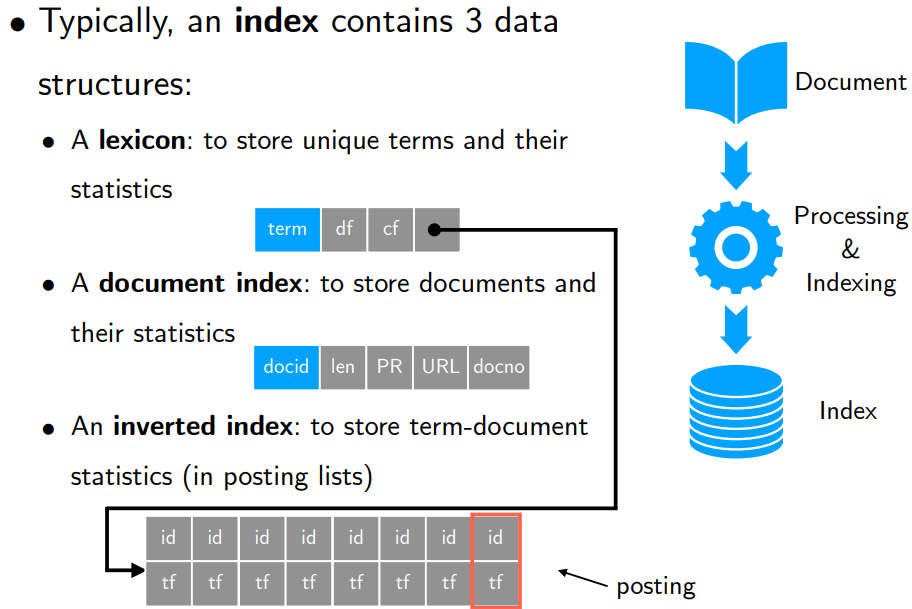

The complete **Index** data structure requires 4 main elements:
* **Lexicon**: maps each index term to its termid, the length of the associated posting list, the total number of occurrences of the term in the whole collection, etc.
* **Document index**: maps each docid to the corresponding documents, if necessary with some additional information on the document
* **Inverted Index**: maps each termid to its posting list.
* **Properties** file, containing statistics about the collection as a whole, such as the total number of documents, of terms, etc.


Data structures implementation
* the lexicon will be a `dict` from the term as string to a dataclass composed by

| Feature| Type |
| :-- | :-- |
| term id | integer number |
| document frequency | integer number
| collection term frequency| integer number

* the document index will be a dict from the docid as int to the document name, or **docno**, as string

* the inverted file will be composed by two maps:
  * a map (dict) from a termid as int and a posting list of docids, as ints;
  * a map (dict) from a termid as int and a posting list of (in document) term frequencies, as ints;

Simplest way to store objects on disk is use Python `pickle` module, which implements binary protocols for serializing and de-serializing a Python object structure. “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy. Pickling (and unpickling) is alternatively known as “serialization”, “marshalling,” or “flattening”.

In [6]:
from array import array
from tqdm import tqdm
from tqdm.auto import tqdm
import pickle
import humanize

# utility function for print pickle size of input file
def print_pickled_size(var_name, var):
    os.makedirs('./tmp', exist_ok=True)
    with open(f"./tmp/{var_name}.pickle", 'wb') as f:
        pickle.dump(var, f)
    print(f'{var_name} requires {humanize.naturalsize(os.path.getsize(f"./tmp/{var_name}.pickle"))}')
    os.remove(f"./tmp/{var_name}.pickle")
    os.removedirs('./tmp')

## 2.1 Compression


TODO

Qui volevo fargli vedere Hip e Zipf laws ma mi satura la ram e non funziona su colab

Al massimo possiamo farla vedere con Vaswani o prendendo quelle delle slide

Data structures for large collections require lot of space so is reasonable to find a way for storing space reduction and since most of space is required by posting list focus can be on **integer compression**.

Even compression theory show two different posting list compression techniques, **Binary Code** and **Variable-Byte code**, only the latter can be implemented using Python since the programming language is *not oriented to bit manipulation*

### Variable-Byte Code

Variable-Byte code was implemented even work with byte-aligned codewords favours implementation simplicity and decoding speed instead of compression effectiveness.

* The **variable-byte code** $VB(x)$ computes the binary representation $bin(x)$ of $x$, that is then splitted into a suitable sequence of bytes.
* For each byte:
    * 7 bits, called **data bits**, are allocated for the representation of $x$;
    * 1 bit, called **control bit** is used to signal the continuation/end of the stream of bytes.

**Encoding** `vbyte_encode`

Input: number, e.g. x=300

1. Compute binary representation of x, $bin(x)$ = `100101100`
2. Split $bin(x)$ into 7 bit chunk

chunk1 = `001100` (rightmost 6 bits) chunk2 = `1001011` (remaining bits)

3. Add data bit to each chunk, where control bit is 1 for last chunk and 0 for all the others resulting in

byte1 = `10001100` byte2 = `10011011`

Output: [`10001100`, `10011011`]



**Decoding** `decode_concatenated_vbyte`

Input: Sequence of bytes, e.g. x=[`10001100`, `10011011`]

1. Find and remove data bit

byte1 = `1001011` byte2 = `001100`

2. Combine byte in `100101100`
3. Convert from binary to decimal

Output: 300

`tqdm` library allows progress bar visualisation

In [7]:
# TODO rivedere commenti

# N.B.: PRINT ONLY FUNCTION, NOT ACTUALLY USEFULL
def print_VBEncode(n):
    byte = []
    while True:
        byte.append(n % 128) # Append 7 bits with most significant bit (control bit) set to 0
        if n < 128:
            break
        n //= 128
    byte[0] += 128 # Set the most significant bit (control bit) set to 1
    return byte[::-1] # We provide the resulting list in reverse order

# N.B.: PRINT ONLY FUNCTION, NOT ACTUALLY USEFULL
def VBEncodeList(n_list):
    b = []
    for n in n_list:
        b.extend(print_VBEncode(n))
    return b

# N.B.: PRINT ONLY FUNCTION, NOT ACTUALLY USEFULL
def print_VBDecode(byte_list):
    n_list = []
    n = 0
    for b in byte_list:
        if b < 128:
            n = 128 * n + b
        else:
            n = 128 * n + b - 128
            n_list.append(n)
            n = 0
    return n_list

def vbyte_encode(number):
    bytes_list = array('B')
    while True:
        byte = number & 0x7F
        number >>= 7
        if number:
            bytes_list.append(byte)
        else:
            bytes_list.append(0x80 | byte)
            break
    return bytes(bytes_list)


def delta_vbyte_encode(numbers):
    """
    Codifica una lista di numeri con delta encoding e VByte.
    """
    result = array('B')
    prev_docid = 0
    for docid in numbers:
        delta = docid - prev_docid
        result.extend(vbyte_encode(delta))
        prev_docid = docid
    return bytes(result)


def batch_vbyte_encode(numbers):
    """
    Codifica una lista di numeri con VByte in batch.
    """
    result = array('B')
    for number in numbers:
        result.extend(vbyte_encode(number))
    return bytes(result)

# Decode
def decode_concatenated_vbyte(encoded_bytes):
    decoded_numbers = []
    current_number = 0
    shift_amount = 0

    for byte in encoded_bytes:
        if byte & 0x80:  # Data bit found, end of number
            current_number |= (byte & 0x7F) << shift_amount
            decoded_numbers.append(current_number)
            current_number = 0
            shift_amount = 0
        else:  # Continue
            current_number |= (byte & 0x7F) << shift_amount
            shift_amount += 7

    return decoded_numbers


def decode_vbyte_with_delta(encoded_bytes):
    """
    Decodifica una lista concatenata di numeri codificati con vbyte
    e ricostruisce i valori originali applicando la delta decoding.
    """
    deltas = decode_concatenated_vbyte(encoded_bytes)  # Ottieni i delta
    docids = []
    prev_docid = 0

    for delta in deltas:
        docid = prev_docid + delta  # Ricostruisci il valore originale
        docids.append(docid)
        prev_docid = docid  # Aggiorna l'ultimo docid

    return docids


def compress_index(lexicon, inv_d, inv_f):
    """
    Comprimi gli indici invertiti dei documenti e delle frequenze usando la codifica VByte con delta.
    """
    compressed_inv_d = {}
    compressed_inv_f = {}

    for term, (termid, df, _) in tqdm(lexicon.items(), desc="Compressing lists", unit="term"):
        docids = inv_d[termid]
        freqs = inv_f[termid]

        # Delta encoding per i docids
        compressed_inv_d[termid] = delta_vbyte_encode(docids)
        assert decode_vbyte_with_delta(compressed_inv_d[termid]) == docids

        # Compressione standard per le frequenze
        compressed_inv_f[termid] = batch_vbyte_encode(freqs)
        assert decode_concatenated_vbyte(compressed_inv_f[termid]) == freqs

    return compressed_inv_d, compressed_inv_f

TODO Qui mettiamo tipo un test per far vedere che le funzioni di compressione funzionano come devono

## 2.2 Building the inverted index

`build_index` function:

input: `filepath` = path of file we want process and `batch_size` = 10000

output: inverted index, document index, lexicon and collection statistics

In [8]:
import pandas as pd
from tqdm.auto import tqdm
from collections import Counter

def build_index(filepath, batch_size=10000):
    # input file is divided in batches time consunming optimization
    # total_documents is total number of documents used for progress bar construction
    total_documents = sum(1 for _ in open(filepath)) # get total number of documents
    # Data structures inizialisation
    lexicon = {} # lexicon, dict of {term_id, df, tf}
    inv_d = {} # {map from term_id to doc_id}
    inv_f = {} # {map from term_id to term}
    doc_index = [] # document info
    total_dl = 0 # sum of all document lengths
    num_docs = 0 # number of document processed in the collection
    termid = 0

    with open(filepath, 'r') as file:
        batch = []
        # progress bar setup
        with tqdm(total=total_documents, desc="Processing documents", unit="doc") as pbar:
            for line in file: # for every document
                # batch creation
                batch.append(line.strip())
                # when the batch is full, we process it
                if len(batch) >= batch_size:
                    for line in batch:
                        # get doc and doc_id
                        doc_id, text = line.split('\t', 1) # '1' specifies the number of splits
                        doc_id = int(doc_id) # usful if is docNo instead of docid
                        # apply preprocess function to the document
                        tokens = preprocess(text)
                        # count term frequency for every term in the document
                        token_tf = Counter(tokens)
                        # Data structures update
                        for token, tf in token_tf.items():
                            if token not in lexicon:
                                # New term adding
                                lexicon[token] = [termid, 0, 0] # termid, df, tf
                                inv_d[termid], inv_f[termid] = [], [] # docids, freqs
                                termid += 1
                            token_id = lexicon[token][0]  # get termid
                            inv_d[token_id].append(doc_id)  # add doc_id to the list of documents containing the term
                            inv_f[token_id].append(tf)  # add term frequency for this doc
                            # update exsisting one
                            lexicon[token][1] += 1  # increment document frequency (df)
                            lexicon[token][2] += tf  # increment total term frequency (tf)

                        doclen = len(tokens)
                        doc_index.append((str(doc_id), doclen))
                        total_dl += doclen
                        num_docs += 1
                    # update progress bar for each processed document
                    pbar.update(len(batch))
                    batch = []

            # process the remaining documents in the last batch
            if batch:
                for line in batch:
                    doc_id, text = line.split('\t', 1)
                    doc_id = int(doc_id)
                    tokens = preprocess(text)
                    token_tf = Counter(tokens)

                    for token, tf in token_tf.items():
                        if token not in lexicon:
                            lexicon[token] = [termid, 0, 0]
                            inv_d[termid], inv_f[termid] = [], []
                            termid += 1
                        token_id = lexicon[token][0]  # get termid
                        inv_d[token_id].append(doc_id)  # get doc_id to the list of documents containing the term
                        inv_f[token_id].append(tf)  # get term frequency for this doc
                        lexicon[token][1] += 1  # increment document frequency (df)
                        lexicon[token][2] += tf  # increment total term frequency (tf)

                    doclen = len(tokens)
                    doc_index.append((str(doc_id), doclen))
                    total_dl += doclen
                    num_docs += 1
                    pbar.update(1)

    # compute average document length (avdl)
    avdl = total_dl / num_docs if num_docs > 0 else 0

    stats = {
        'num_docs': num_docs,
        'num_terms': len(lexicon),
        'num_tokens': total_dl,
        'avdl': avdl  # Add avdl to stats
    }
    return lexicon, {'docids': inv_d, 'freqs': inv_f}, doc_index, stats

**Lexicon** is a dictonary which maps every term to an array composed by three numbers representing id of the term, document frequency (how many times term t appears in document d) and term frequency (how many times term t appears in overall collection)

```
lexicon  = {
  "term": [termid, df, tf],
}
```




**Inverted Index** is composed by
`{'docids': inv_d, 'freqs': inv_f}`, where:

```
inv_d = {
  termid: [docid1, docid2, ...],
   ..}
      = {
    0: [1, 2, 3],  
    1: [1],
    2: [1,2,1]
   ..}

```

and



```
inv_f = {
  termid: [df1, df2, ...],
  ..}
      = {
    0: [1, 1, 1],
    1: [1],
    2: [1,4,2],
}
```






**Document Index** `doc_index` is a list of tuples in which every docid is associated to its document length

```
doc_index = [(doc_id, doclen), ...]
          = [(1,15), (2,8), ..]
```
meaning that document with `docid=1` has 15 tokens in it, document with `docid=2` has 8 tokens in it and so on



Stats object contains all the usefull elements for the properties file of the collection discussed above



```
stats = {
    'num_docs': num_docs # total number of documents in the collection,
    'num_terms': len(lexicon) # total number of unique terms in the collection
    'num_tokens': total_dl, # total number of tokens
    'avdl': avdl # average document length
}
```



# 2.3 Discorso sulla cache TODO

# 2.4 `InvertedIndex` class and score computation

This class defines overall Index data structures, composed by `PostingListIterator` objects and related function `score` for score computation

# `score_tfidf`

**Term frequency** weight:

\begin{aligned}
w_{t,d} =
\begin{cases}
1 + \log(t_{f,t,d}) & \text{if } tf_{t,d} > 0 \\
0 & \text{otherwise}
\end{cases}
\end{aligned}

where $tf_{t,d}$ = Term Frequency, number of times the term $t$ appears in the document $d$

**Inverse Term frequency** weight:

\begin{aligned}
idf_{t} = log(\frac{N}{df_{t}})
\end{aligned}

where $N$= total number of documents in the collection and $d_{f}$=total number of documents in which term $t$ appears

**TF-IDF** term weight:

\begin{aligned}
w_{t,d} =
\begin{cases}
(1 + \log(t_{f,t,d}))*log(\frac{N}{df_{t}}) & \text{if } tf_{t,d} > 0 \\
0 & \text{otherwise}
\end{cases}
\end{aligned}

Score for a document-query pair is sum over all terms $t in both query $q$ and document $d$

$$s(q,d) = ∑_{t \in q \cup d} w_{t,d}$$

This is the formula we used in our first approach, however comparing the results among our system and a benchmark, we detect a significant difference in the performance as we will discuss in the following pharagraphs. We conducted reasearches in order to undertand the reasons of this difference and decided to adopt the TF-IDF version implemented by Terrier (https://github.com/terrier-org/terrier-core/blob/5.x/modules/core/src/main/java/org/terrier/matching/models/TF_IDF.java).


The formula for the TF-IDF score used in Terrier is:

$$
\text{TF-IDF} = \text{Robertson's TF} \cdot \text{Sparck Jones' IDF}
$$

Where:

$$
\text{Robertson's TF} = \frac{k_1 \cdot tf}{tf + k_1 \cdot \left((1 - b) + b \cdot \frac{\text{dl(d)}}{\text{avdl}}\right)}
$$

$$
\text{Sparck Jones' IDF} = \log\left(\frac{N}{df} + 1\right)
$$

- $k_1$ = constant $ \in [1.2 , 2.0]$ which *normalizes* over frequency. The higher the value, the higher is the relevance of term frequency
- $b$ = constant $\in [0, 1]$ which normalizes over length. The higher the value, the lower is the length relevance
- $dl(d)$ = document length
- $avdl$ = average document length in the collection
- $N$: Total number of documents in the collection.
- $df$: Document frequency of the term.



# `score_bm25`

Althought there are many different versions of BM25 formula implementation, we implemented Okapi BM25 one

$$s(q,d) = \sum_{t_i \in q} \frac{tf_i (d)}{k_1 ( (1-b) + b\frac{dl(d)}{avdl}) + tf_i(d)}$$

Where

* $k_1$ = constant $ \in [1.2 , 2.0]$ which *normalizes* over frequency. The higher the value, the higher is the relevance of term frequency
* $b$ = constant $\in [0, 1]$ which normalizes over length. The higher the value, the lower is the length relevance
* $dl(d)$ = document length
* $avdl$ = average document length in the collection



`PostingListIterator` class is an utility class which helps iteration over posting lists, also including some utility functions and scoring function (described above).

One important method is `get_posting(termid)` which gives as output a posting list iterator object for a specific termid.

`math.inf` is used to represent end of posting lisg

In [9]:
import math
import bisect
from functools import lru_cache


class InvertedIndex:

    class PostingListIterator:
        def __init__(self, docids, freqs, doc, avdl):
            self.docids = docids
            self.freqs = freqs
            self.pos = 0
            self.doc = doc
            self.total_docs_number = len(doc)
            self.avdl = avdl

        def docid(self):
            if self.is_end_list():
                return math.inf
            return self.docids[self.pos]

        def score(self, method='tfidf'):
            if method == 'tfidf':
                return self.score_tfidf()
            elif method == 'bm25':
                return self.score_bm25()
            else:
                raise ValueError("Invalid scoring method")

        ###################################################################################
        @lru_cache(maxsize=512)
        def inner_score_tfidf(self, docid, tf, dl, avdl, total_docs, df): # Robertson's TF, Sparck Jones' idf

            """
            Calculate TF-IDF score of the current document in the posting list.
            """
            if self.is_end_list():
                return math.inf

            # TF-IDF parameters
            b = 0.75
            k_1 = 1.2

            tf = self.freqs[self.pos]

            robertson_tf = k_1 * tf / (tf + k_1 * ((1 - b) + b * (self.doc[self.docid()][1] / self.avdl)))

            sparck_jones_idf = math.log(self.total_docs_number / self.len() + 1)

            # finally calculate tf-idf score
            tfidf = robertson_tf * sparck_jones_idf

            return tfidf

        def score_tfidf(self):

            docid = self.docid()
            tf = self.freqs[self.pos]
            dl = self.doc[docid][1]
            avdl = self.avdl
            total_docs = self.total_docs_number
            df = self.len()  # Document frequency

            return self.inner_score_tfidf(docid, tf, dl, avdl, total_docs, df)

        ###################################################################################
        # new score_bm25 function

        @lru_cache(maxsize=512)
        def inner_score_bm25(self, docid, tf, dl, avdl, total_docs, df):

            if self.is_end_list():
                return math.inf
            else:
                # Standard BM25 parameters
                b = 0.75
                k_1 = 1.2

                # Length of the current document
                dl = self.doc[self.docid()][1]

                # Term frequency in the current document
                tf = self.freqs[self.pos]

                # Total number of documents in the collection
                N = self.total_docs_number

                # Number of documents containing the term
                n = self.len()  # document frequency

                # Calculate document length normalization component (B_j)
                B_j = (1 - b) + b * (dl / self.avdl)

                # Calculate the IDF component
                idf = math.log(N / n)

                # Calculate the BM25 score
                rsv_bm25 = ((tf) / (tf + k_1 * B_j)) * idf

                return rsv_bm25


        def score_bm25(self): # Modified to match the BM25 formula from the slides

            docid = self.docid()
            tf = self.freqs[self.pos]
            dl = self.doc[docid][1]
            avdl = self.avdl
            total_docs = self.total_docs_number
            df = self.len()  # Document frequency

            return self.inner_score_bm25(docid, tf, dl, avdl, total_docs, df)

            ###################################################################################

        def next(self): #, target=None): TODO rimuovere sti commenti
            #if not target:
            if not self.is_end_list():
                self.pos += 1
            #else:
            #    if target > self.docid():
            #        self.pos = bisect.bisect_left(self.docids, target, self.pos)

        def is_end_list(self):
            return self.pos == len(self.docids)


        def len(self):
            return len(self.docids)


    def __init__(self, lex, inv, doc, stats):
        self.lexicon = lex
        self.inv = inv
        self.doc = doc
        self.stats = stats

    def num_docs(self):
        return self.stats['num_docs']

    def avdl(self):
        return self.stats['avdl']

    def get_posting(self, termid):
        # decompress the posting list and return an iterator
        return InvertedIndex.PostingListIterator(decode_vbyte_with_delta(self.inv['docids'][termid]), decode_concatenated_vbyte(self.inv['freqs'][termid]), self.doc, self.stats['avdl'])
        #return InvertedIndex.PostingListIterator(self.inv['docids'][termid], self.inv['freqs'][termid], self.doc, self.stats['avdl'])


    def get_termids(self, tokens):
        return [self.lexicon[token][0] for token in tokens if token in self.lexicon]

    def get_postings(self, termids):
        return [self.get_posting(termid) for termid in termids]


## Building the index for the chosen collection


In [10]:
import os
import pickle

# If the 'pickles' directory does not exist, we first create it
os.makedirs('./pickles', exist_ok=True)

def save_pickles(lex, inv, doc, stats, inv_index):
    # Save the lexicon, inverted lists, and document index to disk
    with open('./pickles/lex.pkl', 'wb') as f:
        pickle.dump(lex, f)
    with open('./pickles/inv.pkl', 'wb') as f:
        pickle.dump(inv, f)
    with open('./pickles/doc.pkl', 'wb') as f:
        pickle.dump(doc, f)
    with open('./pickles/stats.pkl', 'wb') as f:
        pickle.dump(stats, f)
    # Save the inverted index
    with open('./pickles/inv_index.pkl', 'wb') as f:
        pickle.dump(inv_index, f)


if chosen_collection == "msmarco":
    try:
        # Try to open the pickled files, else build the index
        with open('./pickles/inv_index.pkl', 'rb') as f:
            inv_index = pickle.load(f)
            print("Inverted index loaded from pickles")
    except FileNotFoundError:
        print("Inverted index not found, building it...")
        lex, inv, doc, stats = build_index('./collection/'+chosen_collection + '/'+chosen_collection+'.tsv')
        # Compress the inverted lists (approximately 7/10 minutes)
        print_pickled_size('Initial \'inv\' structure', inv)
        inv['docids'], inv['freqs'] = compress_index(lex, inv['docids'], inv['freqs'])
        print_pickled_size('Compressed \'inv\' structure', inv)
        inv_index = InvertedIndex(lex, inv, doc, stats)
        save_pickles(lex, inv, doc, stats, inv_index)
elif chosen_collection == "vaswani":
    # simply build the index each time, as it is very fast
    lex, inv, doc, stats = build_index('./collection/'+chosen_collection + '/'+chosen_collection+'.tsv')
    # Compress the inverted lists
    print_pickled_size('Initial \'inv[\'docids\'var=]\' structure', inv['docids'])
    print_pickled_size('Initial \'inv[\'freqs\']\' structure', inv['freqs'])
    inv['docids'], inv['freqs'] = compress_index(lex, inv['docids'], inv['freqs'])
    print_pickled_size('Compressed \'inv[\'docids\'var=]\' structure', inv['docids'])
    print_pickled_size('Compressed \'inv[\'freqs\']\' structure', inv['freqs'])
    inv_index = InvertedIndex(lex, inv, doc, stats)
    print_pickled_size('Inverted Index', inv)
    # don't save pickles for vaswani, as it is very fast to build the index each time

print(f"Number of documents in the inverted index: {inv_index.num_docs()}")

Inverted index not found, building it...


Processing documents:   0%|          | 0/8841823 [00:00<?, ?doc/s]

Initial 'inv' structure requires 1.6 GB


Compressing lists:   0%|          | 0/1800648 [00:00<?, ?term/s]

Compressed 'inv' structure requires 581.6 MB
Number of documents in the inverted index: 8841823


todo : scrivere anche i tempi, che la preprocess era la parte pesante, che abbiam studiato tutto con cProfile e abbiam visto che era colpa dello stemmer principalmente, ...

First run of the building index code required insual huge amount of time, so we tried to find out most time-hungry functions using `cProfile.run(function(parameters), output_file)` which measures time  required by function given as input and gives output stats

In [11]:
# TODO remove?
# CHIMATA 1 VECCHIO STEMMER
import cProfile
import pstats
import re

'''cProfile.run("build_index('collection/msmarco/msmarco.tsv')", "output.prof")
p = pstats.Stats("output.prof")
p.sort_stats("cumtime").print_stats(10)
os.remove("output.prof")'''

'cProfile.run("build_index(\'collection/msmarco/msmarco.tsv\')", "output.prof")\np = pstats.Stats("output.prof")\np.sort_stats("cumtime").print_stats(10)\nos.remove("output.prof")'

TODO Inserire i tempi richiesti dalla funzione chiamata con lo stemmer di tonnellotto

According to table above, `preprocess(text)` function required most of time, expecially due to the stemmer function called in it.

One possibile solution to reduce time required is to implement trade off described above and use Snowball stemmer instead of `nltk` one with related time required change:

TODO Inserire i tempi richiesti dalla funzione chiamata con lo stemmer nuovo

# Collection stats (?)

In [12]:
print(f"average document length: {inv_index.avdl()}")

average document length: 34.687022122021666


In [13]:
print_pickled_size('inv_index', inv_index)

inv_index requires 750.6 MB


# 3. Queries processing

Once necessary document collection data structures are ready, focus is on query processing step in which we download queries dataset, preprocess every element and then prepare code for different way to process them

TODO **Inserire link download queries msmarco**

At the moment, following code can handle every query's dataset made of

| qid | query
| :--- | :---
1108939 |	what slows down the flow of blood
1112389	| what is the county for grand rapids, mn
1128373 | iur definition
1127622	| meaning of heat capacity

Where
* `qid` = query id
* `query` = query text

Preprocess of each query is needed since dataset provides *human-authored text*

Main distinction in query processing can be made over:

| Type | Corresponding Logic Operator | Output
| :--- | :--- | :---
**Conjunctive** |	AND | All documents containing ALL terms of the query
**Disjunctive** | OR | All documents containing AT LEAST ONE term of the query

There are two possible way of document retrieval:

1. **Boolean Retrieval**:

* Return all document having same terms of the queries
* Suitable for small collections
* Returns all documents matching the query

2. **Ranked Retrieval**:

* Returns only top-k documents based on scoring functions (discussed below)
* Suitable for large collections

When processing a query in **conjunctive mode** in **ranked retrieval**, no special differences arise with respect to the boolean retrieval: final results list is computed by intersecting the posting lists, they are scored one by one, then a sorted list of the top $K$ documents is returned.

When a query is processed in **disjunctive mode**, the **boolean retrieval** algorithm must take into account the management of the scores of the processed documents as well as the identification of the top $K$ documents with the highest scores.

To do so, we implement a simple `TopQueue` class, which stores the top $K$ (score, docid) tuples, using an heap, i.e., a binary tree for which every parent node has a value less than or equal to any of its children, whose implementation is provided as functions in the `heapq` module.

For just explained reasons and since we're handling a large collection, boolean retrieval was not considered suitable for this project.

In [14]:
import gzip

# In realta il fatto che chosen collection sia vaswani o msmarco dovrebbe essere controllato sopra
if chosen_collection not in ["vaswani", "msmarco"]:
    raise ValueError("chosen_collection must be one of ['vaswani', 'msmarco']")

if chosen_collection == "msmarco":
    # Download and extract queries
    if not os.path.exists('./collection/msmarco/msmarco-queries.tsv'):
        url = 'https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-test2019-queries.tsv.gz'
        gdown.download(url, './collection/msmarco/msmarco-test2019-queries.tsv.gz', quiet=False)
        with gzip.open('./collection/msmarco/msmarco-test2019-queries.tsv.gz', 'rt') as f_in:
            with open('./collection/msmarco/msmarco-queries.tsv', 'w') as f_out:
                f_out.write(f_in.read())
        os.remove('./collection/msmarco/msmarco-test2019-queries.tsv.gz') # delete the compressed file
    queries = pd.read_csv('./collection/msmarco/msmarco-queries.tsv', sep='\t', header=None)
    queries.columns = ['qid', 'query']
    print("Number of queries: ",len(queries))

    if not os.path.exists('./collection/msmarco/msmarco-qrels.txt'):
        url = 'https://trec.nist.gov/data/deep/2019qrels-pass.txt'
        gdown.download(url, './collection/msmarco/msmarco-qrels.txt', quiet=False)
    qrels = pd.read_csv('./collection/msmarco/msmarco-qrels.txt', sep=' ', header=None)
    qrels.columns = ['qid', 'Q0', 'docid', 'rating']
    print("Number of relevance judgments: ",len(qrels))


elif chosen_collection == "vaswani":
    queries = pd.DataFrame(vaswani_dataset.queries_iter())
    queries.columns = ['qid', 'query']
    print("Number of queries: ",len(list(vaswani_dataset.queries_iter())))
    if not os.path.exists('./collection/vaswani/vaswani-queries.tsv'):
        queries.to_csv('./collection/vaswani/vaswani-queries.tsv', sep='\t', header=False, index=False)
    qrels = pd.DataFrame(vaswani_dataset.qrels_iter())
    qrels.columns = ['qid', 'docid', 'relevance', 'iteration']
    qrels['docid'] = (qrels['docid'].astype(int) - 1).astype(str) # convert to 0-based indexing

    if not os.path.exists('./collection/vaswani/vaswani-qrels.txt'):
        qrels.to_csv('./collection/vaswani/vaswani-qrels.txt', sep='\t', header=False, index=False)
    print("Number of relevance judgments: ",len(list(vaswani_dataset.qrels_iter())))

Downloading...
From: https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-test2019-queries.tsv.gz
To: /content/collection/msmarco/msmarco-test2019-queries.tsv.gz
100%|██████████| 4.28k/4.28k [00:00<00:00, 941kB/s]


Number of queries:  200


Downloading...
From: https://trec.nist.gov/data/deep/2019qrels-pass.txt
To: /content/collection/msmarco/msmarco-qrels.txt
100%|██████████| 187k/187k [00:00<00:00, 517kB/s]

Number of relevance judgments:  9260


`QueriesDataset` is a class for query dataset manipulation and utility functions providing

| Function | Meaning
| :--- | :---
`__init__(self, dataframe)` | inizialisation: starting from input dataframe creates list of `Query` object  (`namedtuple`)
`queries_iter(self)` | output an iterator over a list of queries
`queries_count(self)` | output total number of queries
`get_query(self, query_id)` | output specific query for given input id

Every `Query` is an object composed by

| Field | Meaning
| :--- | :---
`query_id` | query id
`text` | query text


`queries.columns = ['query_id', 'text']` renames columns fields

In [15]:
from collections import namedtuple

class QueriesDataset:
    def __init__(self, df):
        self.queries = [Query(row.query_id, row.text) for row in df.itertuples()]

    def queries_iter(self):
        return iter(self.queries)

    def queries_count(self):
        return len(self.queries)

    def get_query(self, query_id):
        return self.queries[query_id]


Query = namedtuple('Query', ['query_id', 'text'])
queries.columns = ['query_id', 'text']
queries_dataset = QueriesDataset(queries)
print("The number of queries is: ", queries_dataset.queries_count())

The number of queries is:  200


First, we need a `TopQueue` class, which stores the top-K  (score, docid) tuples, using an heap

`TopQueue` class has following input parameters:

| Parameter | Object | Meaning
| :--- | :--- | :---
`k` | number | Top-k queue's length
`threshold` | number | Minimum score to let the query enter the queue

and is made of:

| Parameter | Object | Meaning
| :--- | :--- | :---
`self.queue` | list | Top-k queue
`self.k` | number | Top-k queue's length
`self.threshold` | number | Minimum score to let the query enter the queue

In [16]:
import heapq

class TopQueue:
    def __init__(self, k=10, threshold=0.0):
        self.queue = []
        self.k = k
        self.threshold = threshold

    def size(self):
        return len(self.queue)

    def would_enter(self, score):
        return score > self.threshold

    def clear(self, new_threshold=None):
        self.queue = []
        if new_threshold:
            self.threshold = new_threshold

    def __repr__(self):
        return f'<{self.size()} items, th={self.threshold} {self.queue}'

    def insert(self, docid, score):
        if score > self.threshold:
            if self.size() >= self.k:
                heapq.heapreplace(self.queue, (score, docid))
            else:
                heapq.heappush(self.queue, (score, docid))
            if self.size() >= self.k:
                self.threshold = max(self.threshold, self.queue[0][0])
            return True
        return False

#print(sorted(topq.queue, reverse=True)) # print the queue sorted by score

Two main algorithms for **ranked disjunctive** query processing were implemented, **TAAT** and **DAAT**, where the first process posting list one term at a time so compute the score for $t_1$, then for $t_2$ and so on untill no terms are left summing the partial score into accumulator data structure `A = defaultdict(float)` which is simple but memory expensive, and the latter process multiple terms simultaneously looking at one docid at a time only.

| Algorithm | Posting list processing | Pros | Cons
| :--- | :--- | :--- | :---
`taat` | One Term At A Time | Simple and cache friendly | Memory-hungry
`daat` | One Document At A Time | Smaller memory footprint | Lesser cache-friendly


### TAAT

Example of **TAAT** runs

**Posting lists**

| Termid | Posting list [docid, score]|
|---|---|
| $t_1$ | [4, 11], [7, 1], [10, 5] |
| $t_2$ | [7, 13], [9, 3] |

**Step 0**: Accumulator inizialisation

**Step 1**: Result of processing first term $t1$

| Rank | Docid | Score |
|---|---|---|
| 1 | 4 | 11 |
| 2 | 10 | 5 |
| 3 | 7 | 1 |

**Step 2**: Result of processing first term $t2$

| Rank | Docid | Score |
|---|---|---|
| 1 | 7 | 14 |
| 2 | 4 | 11 |
| 3 | 10 | 5 |
| 4 | 9 | 3 |

| input parameter | type | function |
|---|---|---|
| `postings` | List of posting lists | Considering a query a sum of term, for each one there's a posting list and all must be processed |
| `k` | Integer | Represents dimension of top-k queue
| `method` | String | Can be bm25 or tfidf, based on chosen value the method by which score is computed changes

Accumulator `A` is the table in which partial scores are stored.

For every posting list `posting` from list of posting lists `postings` we compute the score using `posting.score()`, untill `currenct_docid == math.inf` which means that even last posting list element has been processed.

In [17]:
from collections import defaultdict

def taat(postings, k=10, method='bm25'):
    # A = Accumulator inizialization
    A = defaultdict(float)
    # for posting list posting related to a single term
    for posting in postings:
        current_docid = posting.docid()
        while current_docid != math.inf:
            # Store the score in the accumulator
            A[current_docid] += posting.score(method)
            # move to next element of the posting list
            posting.next()
            current_docid = posting.docid()
    top = TopQueue(k)
    # try to insert scores into top-k
    for docid, score in A.items():
        top.insert(docid, score)
    # return only top k
    return sorted(top.queue, reverse=True)

query_process function process an input query `query` using an input index `index.

| Code | Meaning |
|---|---|
| `qtokens = set(preprocess(query))` | call preprocess function and return a set of tokens for a given input query |
| `qtermids = index.get_termids(qtokens)` | list of term ids corresponding to the tokens contained in the query |
| `postings = index.get_postings(qtermids)`  | list of posting lists corresponding to the input termids |

In [18]:
def query_process(query, index):
    qtokens = set(preprocess(query))
    qtermids = index.get_termids(qtokens)
    postings = index.get_postings(qtermids)
    return taat(postings)

### DAAT

Example of **DAAT** runs

Posting lists

| Termid | Posting list [docid, score]|
|---|---|
| $t_1$ | [4, 11], [7, 1], [10, 5] |
| $t_2$ | [7, 13], [9, 3] |

**Step 0**: Accumulator inizialisation

**Step 1**: Result of processing docid=4

| Rank | Docid | Score |
|---|---|---|
| 1 | 4 | 11 |

**Step 2**: Result of processing docid=7

| Rank | Docid | Score |
|---|---|---|
| 1 | 7 | 14 |
| 2 | 4 | 11 |

 After a docid is completely scored, it is immediately stored in the top K priority queue, sorted in decreasing order of score, and the algorithm proceeds to evaluate the next docid.

Since there are no differences in score results but in time processing only and most commercial search engines are reported to use a variant of DAAT, we decided to process queries one document at a time, even TAAT is available too.

 In order to traverse the posting lists, the algorithm maintains a state `current` as it proceeds, where the smallest docid yet to be processed appearing in the posting lists is maintained by the `min_doc` helper function.

 `min_docid(postings)` takes as input a list of posting lists and returns minimum document id `min_docid` from the ones in the posting list. It is used to process posting lists simultaneously in correct order

In [19]:
import math

def min_docid(postings):
    min_docid = math.inf
    for p in postings:
        if not p.is_end_list():
            min_docid = min(p.docid(), min_docid)
    return min_docid

def daat(postings, k=10, method='bm25'):
    top = TopQueue(k)
    current_docid = min_docid(postings)
    while current_docid != math.inf:
        score = 0
        next_docid = math.inf
        for posting in postings:
            if posting.docid() == current_docid:
                score += posting.score(method)
                posting.next()
            if not posting.is_end_list():
                next_docid = posting.docid()
        top.insert(current_docid, score)
        current_docid = next_docid
    return sorted(top.queue, reverse=True)

def query_process(query, index):
    qtokens = set(preprocess(query))
    qtermids = index.get_termids(qtokens)
    postings = index.get_postings(qtermids)
    return daat(postings)

In [20]:
# from tqdm import tqdm
# import cProfile
# import pstats

# @profile
# def query_processing(queries_iter, fn):
#     for q in tqdm(queries_iter, desc="Processing queries", total=queries_dataset.queries_count(), unit="query"):
#         query = preprocess(q.text)
#         termids = inv_index.get_termids(query)
#         postings = inv_index.get_postings(termids)
#         res = fn(postings)


# cProfile.run("query_processing(queries_dataset.queries_iter(), taat)", "./perfm/result.prof")
# p = pstats.Stats("./perfm/result.prof")
# p.sort_stats("cumtime").print_stats(25)

---

# 3. Evaluation

Information Retrieval (IR) system performance can be evaluated in terms of

* **Efficiency**: algorithmic costs of IR systems in terms of space and time consumption
* **Effectiveness**: ability of the system to retrieve and properly rank relevant documents and to suppress retrieval of non relevant ones to satisfy as much as possible user's need

Since Efficency was already assesed measuring time and space processing, evaluation of IR system's effectiveness can be done as:

* **Offline evaluation**: no user interaction is required, we assume to have assessors that already told us what is relevant and what is not.
* **Online evaluation**: the IR system is evaluated while interacting with the user, telling us what is relevant and what is not.

This project exploit **offline evaluation** using a Query Relevance Assestment Dataset.

According to **Cranfield paradigm** we have used an experimental collection **$\mathcal{C} = (D,T,A)$**  where:
* $D$ = **corpus** (MSMARCO collection) of documents in the domain of interest;
* $T$ is a set of **topics** (MSMARCO queries) representing the user information needs;
* $A$ is a list of human-made **relevance assessments** representing the *correct answers*, or **ground-truth**, for each topic $t \in T$, the relevant documents in $d \in D$, i.e., they are triplets $(t, d, p)$, where $p$ is the binary or graded **relevance judgement** of $d$ w.r.t. $t$.

As discussed at the beginning of the project, a **qrels** dataset was also needed for following Performance Evaluation section.

Qrels dataset contains the rank (be mind: order is important!) of relevant document ids for each query considered, so the docid stands for the document must be returned in ideally (forse si dice optimal) run.

**Inserire link download qrels msmarco**


A **relevance assessment** (called `qrel` in `ir_datasets`) is composed by:
* a **topic id** (called *query_id* in `ir_datasets`) as in a topic,
* a **docno** (called *doc_id* in `ir_datasets`) as in a document,
* a **judgement** (called *relevance* in `ir_datasets`) as a binary or graded relevance judgment/label, and
* an **iteration**, **UNUSED** and always equal to the string `'0'`.

At the moment, following code can handle a query's dataset made of

| qid | Q0 | docid | rating
| :--- | :--- | :--- | :---
19335 | Q0 | 1017759 | 0
19335 | Q0 | 1082489 | 0
19335 | Q0 | 109063 | 0
.. | .. | .. | ..
19335 | Q0 | 901325 | 0
19335 | Q0 | 901329 | 0
47923 | Q0 | 1200258 | 2
47923 | Q0 | 1236611 | 0
47923 | Q0 | 1296110 | 1
.. | .. | .. | ..

Where

* `qid` = query id
* `Q0` = TREC specific field, not used in this notebook
* `docid` = document id
* `rating` = int from 0 to 3 expressing relevance of the document w.r.t. query

In [21]:
# get the qrels for the chosen collection
if chosen_collection == "vaswani":
    sep = '\t'
else:
    sep = ' '

qrels = pd.read_csv('./collection/'+chosen_collection+'/'+chosen_collection+'-qrels.txt', sep=sep, header=None)

if chosen_collection == "vaswani":
    qrels.columns = ['query_id', 'doc_id', 'relevance', 'iteration']

else:
    qrels.columns = ['query_id', 'Q0', 'doc_id', 'relevance']


qrels['query_id'] = qrels['query_id'].apply(str)
qrels['doc_id'] = qrels['doc_id'].apply(str)
qrels['relevance'] = qrels['relevance'].apply(int)

print("Number of relevance judgments: ",len(qrels))

Number of relevance judgments:  9260


# 3.1 Offline Evaluation

For each topic $t \in T$, the IR system under test uses it as input to search the corpus of documents $D$ and to  produces a *ranked list* of documents $d_1,d_2,d_3,\ldots$ where the higher the document in the ranking the higher is the estimate of its relevance by the IR system. This ranked list, i.e., the output of the IR system, is called **run file**.

A **run file** is a textual file which all mandatory following fields are separated by a tab or a space character:

| Feature | Description
| :--- | :--- |
*topic id* | the topic id as in $T$  
*Q0* | fixed, unused and always  
*docno* | document number as in $D$  
*rank* | the position of the document in the ranked list for the topic
*score* | the score given by the IR system to the document for the topic (a real number), and
*run id* | an identifier, equal for all the lines in the run, of the IR system search.

Example of run file:

```
41 Q0 LA050394-0237 1 0.6342 updrun
41 Q0 LA091294-0164 2 0.4278 updrun
41 Q0 LA040594-0187 3 0.4278 updrun
41 Q0 LA041694-0248 4 0.3197 updrun
41 Q0 LA102394-0113 5 0.3005 updrun
...
42 Q0 LA081794-0171 1 0.7687 updrun
42 Q0 LA031694-0235 2 0.7011 updrun
42 Q0 LA031694-0234 3 0.6950 updrun
```

Following code cell implements `create_run_file` function, which takes as input:

| Feature | Type | Description
| :--- | :--- | :--- |
`queries_dataset` | Queries Dataset object | Already described above
`fn` | function | Can be daat or taat and is the function to implement posting list processing
`k` | integer | Top-k queue length   
`method` | string | String which describes scoring function, can be 'bm25' or 'tfidf'  
`run_id` | string | Run identificator   
`output_file` | string | Path in which store output file

and process every query computing related score to write results over the runfile



```
for q in tqdm(queries_dataset.queries_iter(), desc="Processing queries", total=queries_dataset.queries_count(), unit="query"):
            topic_id = q.query_id
            query = preprocess(q.text)
            termids = inv_index.get_termids(query)
            postings = inv_index.get_postings(termids)
            results = fn(postings, k=k, method=method)
```

In [22]:
import os


def create_run_file(queries_dataset, fn, k, method, run_id, output_file):
    """
    Preprocess the queries and write the results to a run file.
    :param queries_dataset: queries dataset object
    :param fn: Function to process the postings and return the results in the format (score, docid)
    :param run_id: Name identifier for the run
    :param output_file: Output run file
    """
    if not os.path.exists('./results'):
        os.makedirs('./results')
    with open(f"./results/{output_file}", "w") as f:
        for q in tqdm(queries_dataset.queries_iter(), desc="Processing queries", total=queries_dataset.queries_count(), unit="query"):
            topic_id = q.query_id
            query = preprocess(q.text)
            termids = inv_index.get_termids(query)
            postings = inv_index.get_postings(termids)
            results = fn(postings, k=k, method=method)

            if results:
                # Write results to the run file
                for rank, (score, docno) in enumerate(results, start=1):
                    line = f"{topic_id}\tQ0\t{docno}\t{rank}\t{score:.6f}\t{run_id}\n"
                    f.write(line)
            else:
                # Annotate that no results were found for this query
                line = f"{topic_id}\tQ0\tNO_RESULTS\t0\t0.0\t{run_id}\n"
                f.write(line)

    print(f"Run file {output_file} produced successfully.")

In [23]:
# if the folder already exists, delete it
from shutil import rmtree
if os.path.exists('./results'):
    rmtree('./results')

os.makedirs('./results')
create_run_file(queries_dataset, taat, 1000, 'tfidf', "run_tfidf", f"{chosen_collection}_tfidf.run")
create_run_file(queries_dataset, taat, 1000, 'bm25', "run_bm25", f"{chosen_collection}_bm25.run")

Processing queries:   0%|          | 0/200 [00:00<?, ?query/s]

Run file msmarco_tfidf.run produced successfully.


Processing queries:   0%|          | 0/200 [00:00<?, ?query/s]

Run file msmarco_bm25.run produced successfully.


In [24]:
print(inv_index.num_docs())

8841823


Once runfile is obtained we can now use information just stored in it to actually asses performance with some well-know metrics

# 3.2 Measures for IR System

# Set-based Metrics

IR system is casted as a classification problem where every document is either relevant or not-relevant w.r.t. a query. Common metrics are:
* **Precision** $P$: the proportion of **retrieved documents** that are **actually relevant**.
* **Recall** $R$: the proportion of **relevant documents** that are **actually retrieved**.
* **F-1 score** $= \frac{2 \times P \times R}{P+R}$ consider both Precision and Recall

# Rank-based Metrics

Consider also position of the correct relevant document in the returned list

For this aim we were helped by `ir-measures`, a Python package that interfaces with several IR evaluation tools, including trec_eval, gdeval, trectools, and others.

`ir_measures.read_trec_run(run_file_path)` allows trec-formatted file read and subsequently metrics computation, specified by `metrics = [AP(rel=2), nDCG, nDCG@10, Recall(rel=2)@1000, Judged@10]` code line.

Most important measure is **Discounted Cumulative Gain**.

\begin{aligned}
DCG@k =
\begin{cases}
\sum_{i=1}^k r_i & k<b \\
DCG@(k-1) + \frac{r_k}{log_bk} & \text{otherwise}
\end{cases}
= \sum_{i=1}^k \frac{r_i}{max(1, log_b i)}
\end{aligned}

Althought, we used Normalized Discoutned Cumulative Gain bounded in [0, 1] computed as:

$$nDCG@k = \frac{DCG@k}{iDCG@k}$$

where

$iDCG@k$ is $DCG$ is computed for the ideal run, i.e. the relevant documents sorted in descending order of assessed relevance up to rank $k$

# Metrics overview

| Metric | Metric Name | Description
| :--- | :--- | :--- |
$P$ | Precision | How many of relevant documents were actually retrieved
$R$ | Recall | How many retrieved documents are actually relevant
$AP$ | Average Precision | Aritmetich mean of $P$
$MAP$ | Mean Average Precision | Mean of AP over a set of topics
n$DCG$ | Discounted Cumulative Gain | Multi-graded relevance, not recall based
$J$ | Judged | Percentage of results having relevance judgments


All of metrics shown above can be also computed using a cutoff $k$

| Metric | Metric Name | Description
| :--- | :--- | :--- |
$P@k$ | Precision at cutoff $k$ | How many of relevant documents were actually retrieved at cutoff $k$
$R@k$ | Recall at cutoff $k$ | How many retrieved documents are actually relevant at cutoff $k$
$AP@k$ | Average Precision | Aritmetich mean of $P@k$
$MAP@k$ | Mean Average Precision | Mean of AP over a set of topics at cutoff $k$
n$DCG@k$ | Discounted Cumulative Gain | $DCG$ considered at cutoff $k$
$J@k$ | Judged | Percentage of results having relevance judgments Equivalent to P@k with a relevance assestment lower than any judgment.

**Judged@k**

Percentage of results in the top k (cutoff) results that have relevance judgments.
Equivalent to P@k with a rel lower than any judgment.

### Comparison between TF–IDF (RSJ) and BM25 of our IR system



In [25]:
import ir_measures
from ir_measures import *

# Load the run
run_file_tfidf = list(ir_measures.read_trec_run(f'./results/{chosen_collection}_tfidf.run'))

run_file_bm25 = list(ir_measures.read_trec_run(f'./results/{chosen_collection}_bm25.run'))

In [26]:
# List of scoring functions implemented by our IR system
scoring_functions = ['TF-IDF', 'BM25']

# Number of decimal places to round the results
decimals = 3

# List of evaluation measures (metrics)
metrics = [AP(rel=2), nDCG, nDCG@10, Recall(rel=2)@1000, Judged@10]

# Initialize a dictionary to store results from the IR systems
system_measures = {func: {} for func in scoring_functions}

# Iterate over scoring functions and metrics to gather the results
for func in scoring_functions:
    # For system measures (e.g., TF-IDF, BM25) using `ir_measures`
    for metric in metrics:
        if func == 'TF-IDF':
            system_measures[func][metric] = ir_measures.calc_aggregate([metric], qrels, run_file_tfidf).get(metric)
        elif func == 'BM25':
            system_measures[func][metric] = ir_measures.calc_aggregate([metric], qrels, run_file_bm25).get(metric)

By now, we have obtained a system_measures dictonary with following structure:



```
system_measures = {
    'score_computation1': {
        metric_1: value_1,
        metric_2: value_2,
        ...
    },
    'score_computation2': {
        metric_1: value_3,
        metric_2: value_4,
        ...
    }
}
```

Where:

| Feature | Meaning |  
| :--- | :--- |
score_computation | function for score computation, can be either bm25 or tfidf
metric | metric selected
value | value of related metric

Example of system_measures output:



```
system_measures = {
    'TF-IDF': {
        AP(rel=2): 0.512,
        nDCG: 0.740,
        nDCG@10: 0.655,
        Recall(rel=2)@1000: 0.890,
        Judged@10: 0.850
    },
    'BM25': {
        AP(rel=2): 0.625,
        nDCG: 0.810,
        nDCG@10: 0.720,
        Recall(rel=2)@1000: 0.920,
        Judged@10: 0.870
    }
}
```



In [27]:
def print_results(measures):
	# put the results in a dataframe
	df = pd.DataFrame(measures)
	df = df.transpose()
	df = df.round(decimals)
	# Print the results
	print(df)

In [28]:
print_results(system_measures)

        AP(rel=2)  nDCG  nDCG@10  R(rel=2)@1000  Judged@10
TF-IDF      0.288   0.6    0.480          0.754      0.953
BM25        0.288   0.6    0.479          0.754      0.953


Observing the results obtained it is clear that there is a **non-tangible difference** between the two methods. This means that, using parameters `k_1 = 1.2` and `b = 0.75`, BM25 and TF–IDF (RSJ) behave in a similar way on the collection we have selected. Looking at the formulas we used for the two methods (reported in the previous paragraphs), it is clear that, with parameters set in the same way, the results can be comparable. However, for a deeper analysis and to show a more accurate approach, subsequently the comparison between the TF-IDF and BM25 methods, for our system, is replicated via a statistical test.

---

# 3.3 PyTerrier

PyTerrier is a Python framework, which uses the underlying [Terrier.org information retrieval toolkit](http://terrier.org) implementation for many indexing and retrieval operations, making easier to perform IR experiments in Python with mature Terrier platform for the expensive indexing and retrieval operations.

Since PyTerrier itself provides a simple way to asses search engine performance using well-known dataset and metrics, we decided to provide a comparison between our IR system results and PyTerrier results, since the usage of a famous benchmark can confirm if our work was both effective and efficent.

PyTerrier inizialisation is performed with `init()` method since PyTerrier must download Terrier's jar file and start the JVM. Checking with `started()` prevent multiple `init()` calls.

In [29]:
import pyterrier as pt

# note that pt.started() and pt.init() are deprecated

if not pt.java.started():
    # windows only option
    #pt.java.add_option('-Dtrec.encoding=UTF-8')
    pt.java.init()

terrier-assemblies 5.10 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]


Once we have started, we used `pt.datasets.get_datsets(dataset_name)` to return **MSMARCO passages dataset** ( see `pt.datasets.get_list_dataset()` for available ones), composed by

| Feature | Feature Description |  
| :--- | :--- |
qid | query id
query | query text

Related queries

| Feature | Feature Description |  
| :--- | :--- |
qid | query id
query | query text

Related qrels

| Feature | Feature Description |  
| :--- | :--- |
qid | query id
docno | document id
label | relevance

In [30]:
dataset = pt.get_dataset("msmarco_passage")

print(dataset.get_topics("test-2019").head())
print(dataset.get_qrels("test-2019").head())

msmarco-test2019-queries.tsv.gz:   0%|          | 0.00/4.18k [00:00<?, ?iB/s]

       qid                                              query
0  1108939                  what slows down the flow of blood
1  1112389             what is the county for grand rapids mn
2   792752                                     what is ruclip
3  1119729  what do you do when you have a nosebleed from ...
4  1105095                  where is sugar lake lodge located


2019qrels-docs.txt:   0%|          | 0.00/183k [00:00<?, ?iB/s]

     qid    docno  label
0  19335  1017759      0
1  19335  1082489      0
2  19335   109063      0
3  19335  1160863      0
4  19335  1160871      0


In [31]:
# print the number of queries
print(len(dataset.get_topics("test-2019")))

# print the number of relevance judgments
print(len(dataset.get_qrels("test-2019")))

# print the number of unique queries ids in the qrels
print(len(dataset.get_qrels("test-2019")["qid"].unique()))

200
9260
43


`IndexFactory` is a PyTerrier class providing methods to both create or retrieve already existing indexes and `pt.IndexFactory.of(path)` function upload the related path index, the MSMARCO passage terrier stemmed (`variant=terrier_stemmed`) one in this case

In [32]:
# print getCollectionStatistics
index = pt.IndexFactory.of(dataset.get_index(variant='terrier_stemmed'))
print(index.getCollectionStatistics())

data.direct.bf:   0%|          | 0.00/486M [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/177M [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/377M [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/100M [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/0.99k [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/4.47M [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/67.5M [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/193M [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.29k [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/480 [00:00<?, ?iB/s]

Number of documents: 8841823
Number of terms: 1170682
Number of postings: 215238456
Number of fields: 1
Number of tokens: 288759529
Field names: [text]
Positions:   false



`index` object contains now a PyTerrier index instance which can be used to run queries

In [33]:
from pyterrier.measures import *

queries_pt = dataset.get_topics("test-2019")
qrels_pt = dataset.get_qrels("test-2019")

print(queries_pt.head())
print(qrels_pt.head())

       qid                                              query
0  1108939                  what slows down the flow of blood
1  1112389             what is the county for grand rapids mn
2   792752                                     what is ruclip
3  1119729  what do you do when you have a nosebleed from ...
4  1105095                  where is sugar lake lodge located
     qid    docno  label
0  19335  1017759      0
1  19335  1082489      0
2  19335   109063      0
3  19335  1160863      0
4  19335  1160871      0


In [34]:
queries_qids = set(queries_pt["qid"])
qrels_qids = set(qrels_pt["qid"])

# count the number of unique qids in qrels
unique_values_count = qrels_pt["qid"].nunique()

common_qids = queries_qids & qrels_qids
missing_in_qrels = queries_qids - qrels_qids
missing_in_queries = qrels_qids - queries_qids

# Mostra i risultati
print(f"Numero totale di qid in queries: {len(queries_qids)}")
print(f"Numero totale di qid in qrels: {len(qrels_qids)}")
print(f"Numero di qid comuni: {len(common_qids)}")
print(f"Qid mancanti nei qrels: {len(missing_in_qrels)}")
print(f"Qid mancanti nelle queries: {len(missing_in_queries)}")
print(f"Numero di valori univoci nella prima colonna ('qid') di qrels: {unique_values_count}")

# VERSIONE INGLESE SCRITTA DA ANDRE
print(f"Total number of qid in queries: {len(queries_qids)}")
print(f"Total number of qid in qrels: {len(qrels_qids)}")
print(f"Total number of SAME qid in both queries and qrels: {len(common_qids)}")
print(f"Missing qid in qrels: {len(missing_in_qrels)}")
print(f"Missing qid in queries: {len(missing_in_queries)}")
print(f"Unique values in first column ('qid') of qrels: {unique_values_count}")


Numero totale di qid in queries: 200
Numero totale di qid in qrels: 43
Numero di qid comuni: 43
Qid mancanti nei qrels: 157
Qid mancanti nelle queries: 0
Numero di valori univoci nella prima colonna ('qid') di qrels: 43
Total number of qid in queries: 200
Total number of qid in qrels: 43
Total number of SAME qid in both queries and qrels: 43
Missing qid in qrels: 157
Missing qid in queries: 0
Unique values in first column ('qid') of qrels: 43


Our way into search in PyTerrier is called `Retriever`, which is configured by specifying an index and a weighting model.

We now need two Retriever instances, one for TF-IDF score computation and the other for BM25, they both takes queries as input, compute score based on specified scoring function and return list of retrieved document based on score (exactly as our system does described before)

In [35]:
# Definizione dei retriever
TF_IDF = pt.terrier.Retriever.from_dataset('msmarco_passage', 'terrier_stemmed', wmodel='TF_IDF')
BM25 = pt.terrier.Retriever.from_dataset('msmarco_passage', 'terrier_stemmed', wmodel='BM25')

Following code cell describes input parameters for test phase:

| Parameter | Description |  
| :--- | :--- |
scoring_functions | scoring functions allowed used for experiments
decimals | number of decimal digits allowed
metrics | metrics we are interested in (described above)

`pyterrier_measures` is a dictionary for results storing, while `pt.Experiment` allow a pipeline implementation for experiment step

In [36]:
# List of scoring functions (IR systems)
scoring_functions = ['TF-IDF', 'BM25']

# Number of decimal places to round the results
decimals = 3

# List of evaluation measures (metrics)
metrics = [AP(rel=2), nDCG, nDCG@10, Recall(rel=2)@1000, Judged@10]

pyterrier_measures = {func: {} for func in scoring_functions}


# Iterate over scoring functions and metrics to gather the results
for func in scoring_functions:

    # For PyTerrier results (e.g., TF-IDF, BM25)
    experiment_results = pt.Experiment(
        [TF_IDF, BM25],
        queries_pt,
        qrels_pt,
        eval_metrics=[metric for metric in metrics],
        names=scoring_functions
    )

    # Extract results for each metric in the experiment and store in pyterrier_measures
    for metric in metrics:
        pyterrier_measures[func][metric] = experiment_results.loc[experiment_results['name'] == func, str(metric)].values[0]


In [37]:
# print the results
print_results(pyterrier_measures)

        AP(rel=2)   nDCG  nDCG@10  R(rel=2)@1000  Judged@10
TF-IDF      0.286  0.593    0.478          0.755      0.958
BM25        0.286  0.593    0.480          0.755      0.958


For completeness we report the same metrics that we calculated on our system also for PyTerrier. Here too it is possible to notice that there is **no appreciable difference** between the two methods.

We can consider values obtained a suitable benchamrk for our system testing step.

# 3.4 IR Systems Comparison

Following subsection covers expreriment comparison made over both our system and pyterrier library using `comparison` function, taking as input

| Feature | Feature Description |  
| :--- | :--- |
qid | query id
query | query text

For every metric we compute both our custom system results and PyTerrier results, then we exploit absolute difference between them.

All values are saved into a `pandas` dataframe for reliability

In [38]:
# Iterate through each scoring function and create a comparison DataFrame for it
def comparison(func, metrics, system_measures, pyterrier_measures, decimals):
    # Prepare comparison data for the current scoring function
    comparison_data = {
        'Metric': metrics,
        func + ' System': [system_measures[func].get(m, None) for m in metrics],
        func + ' PyTerrier': [pyterrier_measures[func].get(m, None) for m in metrics],
        func + ' Difference': [
            pyterrier_measures[func].get(m, None) - system_measures[func].get(m, None)
            for m in metrics
        ]
    }

    # Convert to DataFrame for better readability
    comparison_df = pd.DataFrame(comparison_data)

    # reverse columns and rows
    comparison_df = comparison_df.transpose()

    # adjust column names
    comparison_df.columns = comparison_df.iloc[0]

    # drop the first row
    comparison_df = comparison_df[1:]

    # round values for better readability
    comparison_df = comparison_df.round(decimals)

    # Print the comparison DataFrame for the current scoring function
    print(f"Comparison for {func}:\n")
    print(comparison_df)


In [39]:
comparison('TF-IDF', metrics, system_measures, pyterrier_measures, decimals)

Comparison for TF-IDF:

Metric            AP(rel=2)      nDCG   nDCG@10 R(rel=2)@1000 Judged@10
TF-IDF System      0.288007  0.599802  0.480424      0.753839  0.953488
TF-IDF PyTerrier   0.286342  0.593198   0.47831      0.754831   0.95814
TF-IDF Difference -0.001666 -0.006604 -0.002113      0.000992  0.004651


Comparison among our system and PyTerrier, considering TF-IDF method:
   - **AP**, **nDCG**, and **nDCG@10** are marginally higher in our system, this suggests that our system places relevant documents slightly higher in the ranking.
   - **R(rel=2)@1000** and **Judged@10** are slightly higher for PyTerrier, indicating that PyTerrier finds a few more relevant documents at lower ranks and has a slightly higher proportion of judged documents at the top 10.

In any case, **the difference is very low overall.**
A statistical significance test could confirm if these small metric differences are truly meaningful or likely due to randomness. We will see soon.


In [40]:
comparison('BM25', metrics, system_measures, pyterrier_measures, decimals)

Comparison for BM25:

Metric          AP(rel=2)      nDCG   nDCG@10 R(rel=2)@1000 Judged@10
BM25 System      0.288028  0.599523  0.478785       0.75355  0.953488
BM25 PyTerrier   0.286448  0.593433   0.47954      0.755332   0.95814
BM25 Difference -0.001581  -0.00609  0.000755      0.001783  0.004651


Comparison among our system and PyTerrier, considering BM25 method:
   - **AP** and **nDCG** are marginally higher for our BM25, this points to a small edge in ranking the most relevant documents near the top.
   - PyTerrier’s BM25 shows a small advantage in **nDCG@10**, **R(rel=2)@1000**, and **Judged@10**. This suggests PyTerrier slightly improves how results are distributed in the top-10 and retrieves a tiny bit more relevant content overall.

In any case, **the difference is very low overall.**
A statistical significance test could confirm if these small metric differences are truly meaningful or likely due to randomness. We will see soon.


In [41]:
comparison_data = {
    'Metric': metrics,
    func + ' System': [system_measures[func].get(m, None) for m in metrics],
    func + ' PyTerrier': [pyterrier_measures[func].get(m, None) for m in metrics],
    func + ' Difference': [
        pyterrier_measures[func].get(m, None) - system_measures[func].get(m, None)
        for m in metrics
    ],
    func + ' Percentage Difference': [
        ((pyterrier_measures[func].get(m, None) - system_measures[func].get(m, None)) /
         system_measures[func].get(m, None) * 100) if system_measures[func].get(m, None) else None
        for m in metrics
    ]
}

<Figure size 1000x600 with 0 Axes>

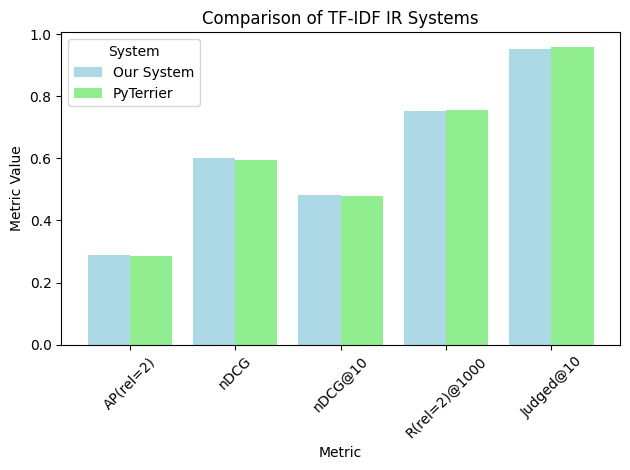

<Figure size 1000x600 with 0 Axes>

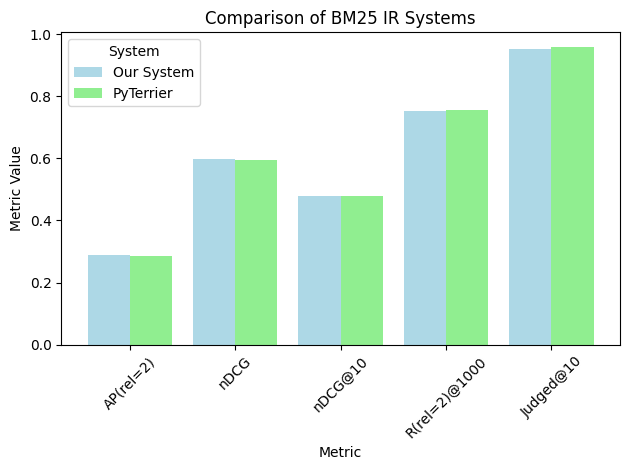

In [42]:
import matplotlib.pyplot as plt

#metrics = [AP(rel=2), nDCG, nDCG@10, Recall(rel=2)@1000]

# Example for one scoring function (TF-IDF)
for func in scoring_functions:
    # Prepare data for barplot
    comparison_df = pd.DataFrame({
        'Metric': metrics,
        'System': [system_measures[func].get(m, None) for m in metrics],
        'PyTerrier': [pyterrier_measures[func].get(m, None) for m in metrics]
    })

    # Set plot size and style
    plt.figure(figsize=(10, 6))
    comparison_df.set_index('Metric').plot(kind='bar', width=0.8, color=['lightblue', 'lightgreen'])

    plt.title(f'Comparison of {func} IR Systems')
    plt.ylabel('Metric Value')
    plt.xlabel('Metric')
    plt.xticks(rotation=45)
    plt.legend(title='System', labels=['Our System', 'PyTerrier'])
    plt.tight_layout()
    plt.show()

The results presented previously are graphically reported here. Looking at the graphs, you immediately notice how the two IR systems are **comparable in every metric**, visually confirming what was described above.

# Discussion of why we used the TF-IDF Robertson Spark Jones formula

As covered above, we switched to using the Robertson Sparck Jones variant of TF-IDF after noticing a **significant difference between the version we initially used for this method and PyTerrier**.

Below is the code we initially implemented for TF-IDF, before moving on to the implementation adopted by Terrier.



```
def score_tfidf(self):

    if self.is_end_list():
        return math.inf
    
    tf = self.freqs[self.pos]
                
    if tf > 0:
        wtd = 1 + math.log(tf)
    else:
        wtd = 0 # avoid log(0)
    
    df = self.len()  # document frequency
    if df > 0:
        idf = math.log(self.total_docs_number / df)
    else:
        idf = 0  # avoid log(0)

    tfidf = wtd * idf

    return tfidf
```



## Comparison for TF–IDF (initial approach)


These are the results we got when we compared our system's TF-IDF method with PyTerrier as a benchmark.



| Metric            | AP(rel=2) | nDCG     | nDCG@10  | R(rel=2)@1000 | Judged@10 |
|-------------------|-----------|---------:|---------|--------------:|----------:|
| **TF–IDF System**     | 0.228651  | 0.516445 | 0.413522 | 0.698103       | 0.75814   |
| **TF–IDF PyTerrier**  | 0.286342  | 0.593198 | 0.47831  | 0.754831       | 0.95814   |
| **TF–IDF Difference** | 0.057691  | 0.076753 | 0.064789 | 0.056728       | 0.20000   |

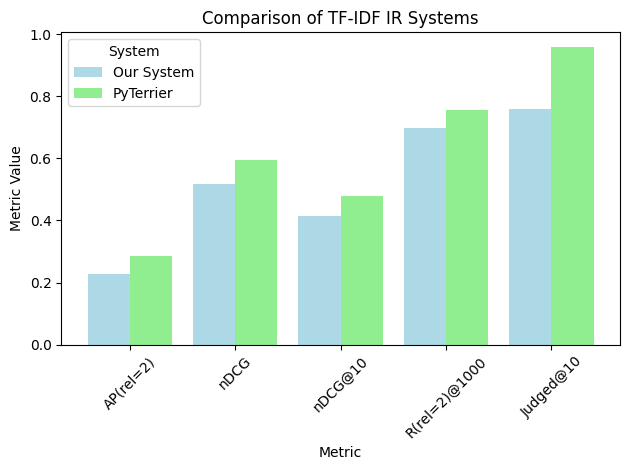


It is enough to look at the graph to appreciate **a clear difference**.

Below we also report the statistical test which highlights **a significant difference** demonstrated by values ​​for p-values ​​below 0.05.


| name               | AP(rel=2) | AP(rel=2)+ | AP(rel=2)- | AP(rel=2) p-value | nDCG   | nDCG+ | nDCG- | nDCG p-value | nDCG@10 | nDCG@10+ | nDCG@10- | nDCG@10 p-value | R(rel=2)@1000 | R(rel=2)@1000+ | R(rel=2)@1000- | R(rel=2)@1000 p-value |
|--------------------|:---------:|:---------:|:---------:|:------------------:|:------:|:-----:|:-----:|:------------:|:-------:|:-------:|:-------:|:---------------:|:------------:|:--------------:|:--------------:|:----------------------:|
| **PyTerrier TF–IDF (RSJ)**  | 0.286     | NaN       | NaN       | NaN                | 0.593  | NaN   | NaN   | NaN          | 0.478   | NaN      | NaN      | NaN             | 0.755        | NaN            | NaN            | NaN                   |
| **OurSystem TF–IDF**  | 0.229     | 8.0       | 35.0      | 0.0                | 0.516  | 6.0   | 37.0  | 0.0          | 0.414   | 14.0     | 27.0     | 0.009           | 0.698        | 10.0           | 23.0           | 0.023                 |


This is why we moved to the TF-IDF Robertson Sparck Jones implementation, achieving the satisfactory results shown before this discussion.

# Evaluating baselines (significance testing, paired $t$-test, 𝑝 < 0.05)

Significance testing can be performed by specifying the index of the transformer we want to consider for our baseline using  `baseline` parameter which enables significance testing (paired $t$-test), reporting, for each metric, the $p$-value, as well as showing the number of queries improved and degraded w.r.t. the baseline.

For the baseline, values are obviously `NaN`.

In [43]:
from scipy.stats import ttest_rel
import numpy as np

metrics = [AP(rel=2), nDCG, nDCG@10, Recall(rel=2)@1000]

def evaluate_baseline(metric, baseline_index = 0):
    # Baseline Index: 0 for TF-IDF, 1 for BM25

    # Compute per-topic AP scores for both TFIDF and BM25
    tfidf_scores = {}
    bm25_scores = {}

    for res in ir_measures.iter_calc([metric], qrels, run_file_tfidf):
        tfidf_scores[res.query_id] = res.value

    for res in ir_measures.iter_calc([metric], qrels, run_file_bm25):
        bm25_scores[res.query_id] = res.value

    # Ensure we have common queries
    common_queries = set(tfidf_scores.keys()).intersection(bm25_scores.keys())

    tfidf_list = [tfidf_scores[q] for q in common_queries]
    bm25_list = [bm25_scores[q] for q in common_queries]

    # Perform paired t-test
    t_stat, p_val = ttest_rel(tfidf_list, bm25_list)

    # Compute mean AP for each system
    mean_tfidf = np.mean(tfidf_list)
    mean_bm25 = np.mean(bm25_list)

    # Compute additional metrics relative to baseline
    if baseline_index == 0:  # TF-IDF is baseline
        baseline_name = "TF-IDF"
        compare_name = "BM25"
        plus = sum(1 for tf, bm in zip(tfidf_list, bm25_list) if bm > tf)
        minus = sum(1 for tf, bm in zip(tfidf_list, bm25_list) if bm < tf)
        baseline = mean_tfidf
        compare = mean_bm25
    else:  # BM25 is baseline
        baseline_name = "BM25"
        compare_name = "TF-IDF"
        plus = sum(1 for tf, bm in zip(tfidf_list, bm25_list) if tf > bm)
        minus = sum(1 for tf, bm in zip(tfidf_list, bm25_list) if tf < bm)
        baseline = mean_bm25
        compare = mean_tfidf

    # Create the DataFrame to match the desired output
    df_results = pd.DataFrame({
        'name': [baseline_name, compare_name],
        str(metric) : [baseline, compare],
        str(metric)+' +': [np.nan, plus],  # + only for the non-baseline system
        str(metric)+' -': [np.nan, minus],  # - only for the non-baseline system
        'p-value': [np.nan, p_val]
    })

    # Round values for better readability
    df_results = df_results.round(decimals)

    # Display the output
    print(df_results)


In [44]:
evaluate_baseline(AP(rel=2))

     name  AP(rel=2)  AP(rel=2) +  AP(rel=2) -  p-value
0  TF-IDF      0.288          NaN          NaN      NaN
1    BM25      0.288         12.0         20.0    0.905


In [45]:
evaluate_baseline(nDCG)

     name  nDCG  nDCG +  nDCG -  p-value
0  TF-IDF   0.6     NaN     NaN      NaN
1    BM25   0.6    13.0    23.0    0.474


In [46]:
evaluate_baseline(nDCG@10)

     name  nDCG@10  nDCG@10 +  nDCG@10 -  p-value
0  TF-IDF    0.480        NaN        NaN      NaN
1    BM25    0.479        2.0        2.0    0.396


In [47]:
evaluate_baseline(Recall(rel=2)@1000)

     name  R(rel=2)@1000  R(rel=2)@1000 +  R(rel=2)@1000 -  p-value
0  TF-IDF          0.754              NaN              NaN      NaN
1    BM25          0.754              2.0              2.0    0.737


## T-Test Results for Our System (p < 0.05)

| Metric             | p-value | Interpretation                     |
|--------------------|--------:|------------------------------------|
| **AP(rel=2)**      |  0.905  | Not significant (p > 0.05)         |
| **nDCG**           |  0.474  | Not significant (p > 0.05)         |
| **nDCG@10**        |  0.396  | Not significant (p > 0.05)         |
| **R(rel=2)@1000**  |  0.737  | Not significant (p > 0.05)         |

All of the calculated p-values exceed the 0.05 threshold. Therefore, **none of the differences between TF–IDF and BM25 are statistically significant**. In practical terms, this suggests that any minor performance variations are likely due to random fluctuations rather than systematic disparities, and **both retrieval methods appear to perform equivalently** in this setup.

# PyTerrier evaluating baselines (significance testing, paired $t$-test)

In [48]:
# comparation among TF-IDF and BM25 using PyTerrier (maybe not useful for our project)

pt.Experiment(
    [TF_IDF, BM25],
    queries_pt,
    qrels_pt,
    eval_metrics=[metric for metric in metrics],
    names=scoring_functions,
    round=3,
    baseline=0,
    save_dir='./',
    save_mode="overwrite"
)

,name,nDCG,nDCG@10,AP(rel=2),R(rel=2)@1000,nDCG +,nDCG -,nDCG p-value,nDCG@10 +,nDCG@10 -,nDCG@10 p-value,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,R(rel=2)@1000 +,R(rel=2)@1000 -,R(rel=2)@1000 p-value
0,TF-IDF,0.593,0.478,0.286,0.755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25,0.593,0.480,0.286,0.755,19.0,18.0,0.460364,2.0,2.0,0.419534,17.0,16.0,0.65963,2.0,0.0,0.169991


For completeness we did the same for PyTerrier.
Given these results, **TF–IDF and BM25 perform equivalently** also in this case, and there is no statistically significant evidence favoring one approach over the other.

`perquery` option allow the user to see results for each query looking for further specific information

In [49]:
perquery_results = pt.Experiment(
    [TF_IDF, BM25],
    queries_pt,
    qrels_pt,
    eval_metrics=[metric for metric in metrics],
    names=scoring_functions,
    round=3,
    perquery=True
)

/usr/local/lib/python3.10/dist-packages/pyterrier/pipelines.py:134: UserWarning: 157 topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.
  warn(f'{backfill_count} topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.')
/usr/local/lib/python3.10/dist-packages/pyterrier/pipelines.py:134: UserWarning: 157 topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.
  warn(f'{backfill_count} topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.')


In [50]:
# print results that have value field not NaN
print(perquery_results[perquery_results['value'].notna()])

       name      qid        measure  value
836    BM25  1037798           nDCG  0.433
837    BM25  1037798        nDCG@10  0.153
838    BM25  1037798      AP(rel=2)  0.091
839    BM25  1037798  R(rel=2)@1000  1.000
884    BM25   104861           nDCG  0.731
..      ...      ...            ...    ...
43   TF-IDF   915593  R(rel=2)@1000  1.000
52   TF-IDF   962179           nDCG  0.401
53   TF-IDF   962179        nDCG@10  0.000
54   TF-IDF   962179      AP(rel=2)  0.050
55   TF-IDF   962179  R(rel=2)@1000  1.000

[344 rows x 4 columns]


As expected, no differences between *p-values* for PyTerrier system were discovered

# Significance testing, paired $t$-test among our system and PyTerrier

This sections shows final experiments for our IR system and PyTerrier results for all metrics, using both scoring functions and considering also *p-values*.

In [51]:
import pandas as pd
from scipy.stats import ttest_rel
import numpy as np
import ir_measures
from ir_measures import AP, nDCG, Recall

def compare_systems_detailed(perquery_results, my_system_run, qrels, metrics, scoring_function):
    """
    Compare a scoring function (BM25 or TF-IDF) between your system and PyTerrier using paired t-tests.

    Args:
        perquery_results (pd.DataFrame): PyTerrier per-query results DataFrame.
        my_system_run: Path to your system's run file.
        qrels: Ground truth relevance judgments.
        metrics (list): List of metrics to evaluate (e.g., [AP(rel=2), nDCG()]).
        scoring_function (str): Name of the scoring function ("BM25" or "TF-IDF").

    Returns:
        pd.DataFrame: DataFrame with detailed comparison results for all metrics.
    """
    # Filter PyTerrier per-query results for the scoring function
    pyterrier_results = perquery_results[perquery_results['name'] == scoring_function]

    # Prepare my system's per-query scores
    system_scores = {str(metric): {} for metric in metrics}
    for metric in metrics:
        for res in ir_measures.iter_calc([metric], qrels, my_system_run):
            system_scores[str(metric)][res.query_id] = res.value

    # Prepare data for detailed output
    results = {'name': [f"PyTerrier {scoring_function}", f"OurSystem {scoring_function}"]}

    for metric in metrics:
        metric_name = str(metric)

        # Extract PyTerrier per-query scores for this metric
        pyterrier_metric_scores = pyterrier_results[pyterrier_results['measure'] == metric_name]

        # Ensure only queries present in both systems are compared
        common_queries = set(pyterrier_metric_scores['qid']).intersection(
            system_scores[metric_name].keys()
        )

        # Extract scores for the common queries
        pyterrier_list = [
            pyterrier_metric_scores[pyterrier_metric_scores['qid'] == q]['value'].values[0]
            for q in common_queries
        ]
        system_list = [system_scores[metric_name][q] for q in common_queries]

        # Calculate paired t-test
        t_stat, p_val = ttest_rel(system_list, pyterrier_list)

        # Compute mean scores
        mean_pyterrier = np.mean(pyterrier_list)
        mean_mysystem = np.mean(system_list)

        # Additional metrics
        plus = sum(1 for m, p in zip(system_list, pyterrier_list) if m > p)
        minus = sum(1 for m, p in zip(system_list, pyterrier_list) if m < p)

        # Add results for this metric
        results[metric_name] = [mean_pyterrier, mean_mysystem]
        results[f"{metric_name} +"] = [np.nan, plus]
        results[f"{metric_name} -"] = [np.nan, minus]
        results[f"{metric_name} p-value"] = [np.nan, p_val]

    # Create DataFrame
    df_results = pd.DataFrame(results)
    df_results = df_results.round(decimals)

    return df_results


In [52]:
# Define metrics for evaluation
metrics = [AP(rel=2), nDCG(), nDCG@10, Recall(rel=2)@1000]

# Call the function to compare systems
df_results = compare_systems_detailed(
    perquery_results=perquery_results,
    my_system_run=run_file_tfidf,
    qrels=qrels,
    metrics=metrics,
    scoring_function="TF-IDF"  # Change to "TF-IDF" if needed
)

# Display the detailed results
print(df_results)

               name  AP(rel=2)  AP(rel=2) +  AP(rel=2) -  AP(rel=2) p-value  \
0  PyTerrier TF-IDF      0.286          NaN          NaN                NaN   
1  OurSystem TF-IDF      0.288         19.0         23.0              0.748   

    nDCG  nDCG +  nDCG -  nDCG p-value  nDCG@10  nDCG@10 +  nDCG@10 -  \
0  0.593     NaN     NaN           NaN    0.478        NaN        NaN   
1  0.600    21.0    22.0         0.324    0.480       21.0       20.0   

   nDCG@10 p-value  R(rel=2)@1000  R(rel=2)@1000 +  R(rel=2)@1000 -  \
0              NaN          0.755              NaN              NaN   
1            0.838          0.754             14.0             11.0   

   R(rel=2)@1000 p-value  
0                    NaN  
1                  0.858  


## T-Test Results for TF-IDF (RSJ) (p < 0.05)

| Metric             | p-value | Interpretation                     |
|--------------------|--------:|------------------------------------|
| **AP(rel=2)**      |  0.748  | Not significant (p > 0.05)         |
| **nDCG**           |  0.324  | Not significant (p > 0.05)         |
| **nDCG@10**        |  0.838  | Not significant (p > 0.05)         |
| **R(rel=2)@1000**  |  0.858  | Not significant (p > 0.05)         |

All available p-values exceed 0.05, indicating that any observed performance gaps are likely due to random variation rather than systematic or meaningful differences.
Given these results, **both PyTerrier TF–IDF and our system TF–IDF exhibit effectively equivalent performance**, with no statistically significant advantage for either approach in this particular setup. Confirming what was intuited from the simple previous comparison of the values ​​for each metric.

In [53]:
# Define metrics for evaluation
metrics = [AP(rel=2), nDCG(), nDCG@10, Recall(rel=2)@1000]

# Call the function to compare systems
df_results = compare_systems_detailed(
    perquery_results=perquery_results,
    my_system_run=run_file_bm25,
    qrels=qrels,
    metrics=metrics,
    scoring_function="BM25"  # Change to "TF-IDF" if needed
)

# Display the detailed results
print(df_results)

             name  AP(rel=2)  AP(rel=2) +  AP(rel=2) -  AP(rel=2) p-value  \
0  PyTerrier BM25      0.286          NaN          NaN                NaN   
1  OurSystem BM25      0.288         20.0         22.0              0.744   

    nDCG  nDCG +  nDCG -  nDCG p-value  nDCG@10  nDCG@10 +  nDCG@10 -  \
0  0.593     NaN     NaN           NaN    0.480        NaN        NaN   
1  0.600    18.0    25.0          0.36    0.479       20.0       21.0   

   nDCG@10 p-value  R(rel=2)@1000  R(rel=2)@1000 +  R(rel=2)@1000 -  \
0              NaN          0.755              NaN              NaN   
1            0.936          0.754             14.0             11.0   

   R(rel=2)@1000 p-value  
0                    NaN  
1                  0.758  


## T-Test Results for BM25 (p < 0.05)

| Metric             | p-value | Interpretation                     |
|--------------------|--------:|------------------------------------|
| **AP(rel=2)**      |  0.744  | Not significant (p > 0.05)         |
| **nDCG**           |  0.360  | Not significant (p > 0.05)         |
| **nDCG@10**        |  0.936  | Not significant (p > 0.05)         |
| **R(rel=2)@1000**  |  0.758  | Not significant (p > 0.05)         |

All available p-values exceed 0.05, indicating that any observed performance gaps are likely due to random variation rather than systematic or meaningful differences.
Given these results, **both PyTerrier BM25 and our system BM25 exhibit effectively equivalent performance**, with no statistically significant advantage for either approach in this particular setup. Confirming what was intuited from the simple previous comparison of the values ​​for each metric.

# Trying it out

In [54]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import time
from cachetools import LFUCache


# UI elements
search_bar = widgets.Text(
    placeholder='Type in a query...',
    description='Search:',
    layout=widgets.Layout(width='80%')
)
search_button = widgets.Button(
    description='Search',
    button_style='success',
    tooltip='Execute the query',
    icon='search'
)

score_function_rbtn = widgets.RadioButtons(options=['TF-IDF', 'BM25'], description='Scoring function:', disabled=False)
algo_rbtn = widgets.RadioButtons(options=['TAAT', 'DAAT'], description='Algorithm:', disabled=False)
_style = widgets.HTML(
    "<style>.widget-radio-box {flex-direction: row !important;}.widget-radio-box"
    " label{margin:2px !important;width: 100px !important;}</style>",
    layout=widgets.Layout(display="none"),
)

output_area = widgets.Output()

query_cache = LFUCache(maxsize=120)

def on_search_click(b):
    with output_area:
        clear_output()  # clean previous output
        query = search_bar.value
        if not query.strip():
            print("Please, type in a query.")
            return

        selected_scoring_function = score_function_rbtn.value
        print(f"Selected scoring function: {selected_scoring_function}")
        if selected_scoring_function == 'TF-IDF':
            method = 'tfidf'
        else:
            method = 'bm25'

        selected_algorithm = algo_rbtn.value
        print(f"Selected Algorithm: {selected_algorithm}")

        start_time = time.time()
        # --- WITH CACHE ---
        processed_query = preprocess(query)
        print("processed_query: ", processed_query)
        cache_key = tuple(processed_query)  # Usa la versione preprocessata della query come chiave della cache
        # --- QUERY EXECUTION ---
        processed_query = preprocess(query)
        termids = inv_index.get_termids(processed_query)
        postings = inv_index.get_postings(termids)

        if selected_algorithm == 'TAAT':
            results = taat(postings, method=method)
        else:
            results = daat(postings, method=method)
        # ------------------------
        elapsed_time = (time.time() - start_time) * 1000 # convert in ms

        # finally show the results
        print(f"Top {len(results)} documents:\n")
        for res in results:
            res = (round(res[0], 4), res[1]) # TODO : si potrebbe spostare direttamente nella score function
            print(f" - {res}")
        print(f"\nExecution time: {elapsed_time:.2f} ms")

search_button.on_click(on_search_click)

top_row = widgets.HBox([score_function_rbtn,_style])
middle_row = widgets.HBox([algo_rbtn,_style])
bottom_row = widgets.HBox([search_bar, search_button])

# finally display the UI
display(widgets.VBox([top_row,middle_row, bottom_row]))
display(output_area)

Output()

In [55]:
# CAPE TEST FUNCTION FOR SINGULAR QUERY TIMES

def func(query, selected_algorithm, selected_scoring_function):
    processed_query = preprocess(query)
    termids = inv_index.get_termids(processed_query)
    postings = inv_index.get_postings(termids)
    if selected_algorithm == 'TAAT':
        results = taat(postings, method=selected_scoring_function)
    else:
        results = daat(postings, method=selected_scoring_function)

    return results


# facciamone la cProfile
import cProfile
import pstats
import io

query = "who formed the commonwealth of independent states" if chosen_collection == "msmarco" else "CHARACTERISTICS OF THE SINGLE ELECTRODE DISCHARGE IN THE RARE GASES AT LOW PRESSURES"

pr = cProfile.Profile()
pr.enable()
func(query, 'TAAT', 'tfidf')
pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats(20)
print(s.getvalue())

         26435646 function calls in 14.276 seconds

   Ordered by: cumulative time
   List reduced from 66 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   14.276    7.138 /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3512(run_code)
        2    0.000    0.000   14.276    7.138 {built-in method builtins.exec}
        1    0.012    0.012   14.276   14.276 <ipython-input-55-0f1a12502279>:1(<cell line: 24>)
        1    0.057    0.057   14.264   14.264 <ipython-input-55-0f1a12502279>:3(func)
        1    1.999    1.999   11.676   11.676 <ipython-input-17-99d78c15d401>:3(taat)
  1018080    0.438    0.000    7.564    0.000 <ipython-input-9-e6d651756eac>:22(score)
  1018080    2.092    0.000    7.127    0.000 <ipython-input-9-e6d651756eac>:81(score_tfidf)
  1018080    1.892    0.000    3.821    0.000 <ipython-input-9-e6d651756eac>:57(inner_score_tfidf)
        1    0.000    0.000   